**Загрузка данных**

In [32]:
import pandas as pd
df_offers_path='data/df_offers.csv'
df_orders_path='data/df_orders.csv'
df_placements_path='data/df_placements.csv'
df_stats_path='data/df_stats.csv'

df_offers=pd.read_csv(df_offers_path)
df_placements=pd.read_csv(df_placements_path)
df_orders=pd.read_csv(df_orders_path)
df_stats=pd.read_csv(df_stats_path)



Предпросмотр и предобработка данных


Приведение типов

In [33]:
print('==============Offers info===============')
df_offers.info()
print('==============Placements info==============')
df_placements.info()
print('==============Orders info===============')
df_orders.info()
print('==============Stats info===============')
df_stats.info()


==============Offers info===============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28583 entries, 0 to 28582
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   hash_offer_id     28583 non-null  object 
 1   offer_created_at  28583 non-null  object 
 2   placement_format  28583 non-null  int64  
 3   hash_seller_id    28583 non-null  object 
 4   hash_model_id     28583 non-null  object 
 5   category          28583 non-null  object 
 6   price             28583 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 1.5+ MB
==============Placements info==============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93479 entries, 0 to 93478
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   hash_placement_id     93479 non-null  object
 1   placement_created_at  93479 non-null  object
 2   placement

В следующих таблицах нужно преобразовать типы данных в датафреймах

**Таблица Offers**

offer_created_at - нужно перевести в datetime


**Таблица Placements**

placement_created_at  93479 non-null - нужно перевести в datetime

published_at          87390 non-null - нужно перевести в datetime

Также видно, что часть размещений все еще не опубликована, будем держать в голове.


**Таблица Orders**

order_created_at              71824 non-null  - нужно перевести в datetime

order_status_code_changed_at  71825 non-null  - нужно перевести в datetime

Также в таблице orders присутствуют мусорные пустые колонки, их надо удалить.

Unnamed: 7                    0 non-null      

Unnamed: 8                    0 non-null     

В датасете есть такие странные ошибочные значения даты, поставим им null в таких случаях.

In [34]:
df_orders[df_orders['order_status_code_changed_at']=="1433.0"]

,hash_order_id,order_created_at,hash_placement_id,order_status_code,order_status_code_changed_at,GMV,reward_author,Unnamed: 7,Unnamed: 8
57642,FC7ED57D6B886C8C8F9A01A8A1290C58D9A6BFFFE952F4...,2025-10-20 16:00:00+03:00,",4",2025-10-22 21:00:00+03:00,1433.0,358.0000,NaN,NaN,NaN


In [35]:
df_offers['offer_created_at']=pd.to_datetime(df_offers['offer_created_at'], errors='coerce')
df_placements['placement_created_at']=pd.to_datetime(df_placements['placement_created_at'], errors='coerce')
df_placements['published_at']=pd.to_datetime(df_placements['published_at'], errors='coerce')
df_orders['order_created_at']=pd.to_datetime(df_orders['order_created_at'], errors='coerce')
df_orders['order_status_code_changed_at']=pd.to_datetime(df_orders['order_status_code_changed_at'], errors='coerce') #ставим null

#Также удаляем мусорные колонки из orders
df_orders = df_orders.drop(columns=['Unnamed: 7', 'Unnamed: 8'])

In [36]:
print("Дубликаты в Offers:", df_offers.duplicated().sum())
print("Дубликаты в Placements:", df_placements.duplicated().sum())
print("Дубликаты в Orders:", df_orders.duplicated().sum())
print("Дубликаты в Stats:", df_orders.duplicated().sum())

Дубликаты в Offers: 0
Дубликаты в Placements: 0
Дубликаты в Orders: 0
Дубликаты в Stats: 0


Таблицы без дубликатов, хорошо)

В таблице заказов представлены заказы за всё время, не только за период тестового запуска. Будем считать началом пилота первую публикацию с рекламой. Именно тогда пользователи начинают взаимодействие с новым продуктом.

In [37]:
min_date=df_orders['order_created_at'].min()
max_date=df_orders['order_created_at'].max()
print(f'Первая дата таблицы: {min_date}, последняя дата: {max_date}')

#Давайте найдем дату начала тестового запуска
pilot_data=df_placements['published_at'].min()
print(f'Первая публикация с рекламой: {pilot_data}')

Первая дата таблицы: 2024-12-05 13:00:00+03:00, последняя дата: 2025-10-30 01:00:00+03:00
Первая публикация с рекламой: 2025-07-14 19:00:00+03:00


Как видно, тестовый запуск длился примерно 3 с половиной месяца, в то время как данные по заказам есть больше чем за 8 месяцев

Посмотрим сколько было заказов до и после начала пилота

In [38]:
# Граница между историей и пилотом (первая публикация)
pilot_start = pd.Timestamp('2025-07-14 19:00:00+03:00')

# Разделяем df_orders на исторические и пилотные
df_orders_hist = df_orders[df_orders['order_created_at'] < pilot_start]
df_all_orders_pilot = df_orders[df_orders['order_created_at'] >= pilot_start]
df_ad_orders_pilot = df_all_orders_pilot[df_all_orders_pilot['hash_placement_id'].notna()]

print(f"Исторических заказов (до пилота): {len(df_orders_hist)}")
print(f"Пилотных заказов с размещением (тестовый запуск): {len(df_ad_orders_pilot)}")
print(f"Все заказов во время тестового запуска: {len(df_all_orders_pilot)}")


Исторических заказов (до пилота): 5772
Пилотных заказов с размещением (тестовый запуск): 28148
Все заказов во время тестового запуска: 66052


Мы хотим посмотреть на основные метрики по категориям

In [39]:

df_full = df_placements.copy()

# Добавляем офферы 
df_full = df_full.merge(
    df_offers, 
    on='hash_offer_id', 
    how='left',
    suffixes=('', '_offer')
)

# Добавляем метрики 
df_full = df_full.merge(
    df_stats, 
    on='hash_placement_id', 
    how='left',
    suffixes=('', '_stats')
)

# 4. Добавляем заказы 
df_full = df_full.merge(
    df_orders, 
    on='hash_placement_id', 
    how='outer',  #(FULL OUTER - чтобы сохранить заказы без размещений)
    suffixes=('', '_order')
)


Исследовательский анализ данных (EDA)

Топ категорий по GMV

In [40]:

print('Все категории:')
print(df_full['category'].unique())

top_categories = df_full.groupby('category')['GMV'].sum().sort_values(ascending=False)

print("Рейтинг категорий по GMV:")
print(top_categories)



Все категории:
[nan 'Электроника' 'Дом и дача' 'Транспорт' 'Спорт и отдых' 'Гардероб'
 'Красота и здоровье' 'Хобби и развлечения' 'Бытовая техника'
 'Ремонт и строительство' 'Продукты питания' 'Детские товары'
 'Канцелярские товары' 'Товары для животных' 'Все товары'
 'Товары для геймеров']
Рейтинг категорий по GMV:
category
Гардероб                 46,647,537.0000
Дом и дача               38,425,067.0000
Красота и здоровье       20,881,752.0000
Спорт и отдых            17,775,948.0000
Бытовая техника          17,230,465.0000
Электроника               6,340,324.0000
Детские товары            4,230,606.0000
Хобби и развлечения       3,872,990.0000
Товары для животных       3,185,946.0000
Продукты питания          3,167,176.0000
Канцелярские товары       2,735,388.0000
Транспорт                 2,372,696.0000
Ремонт и строительство    2,019,431.0000
Товары для геймеров         119,692.0000
Все товары                  108,730.0000
Name: GMV, dtype: float64


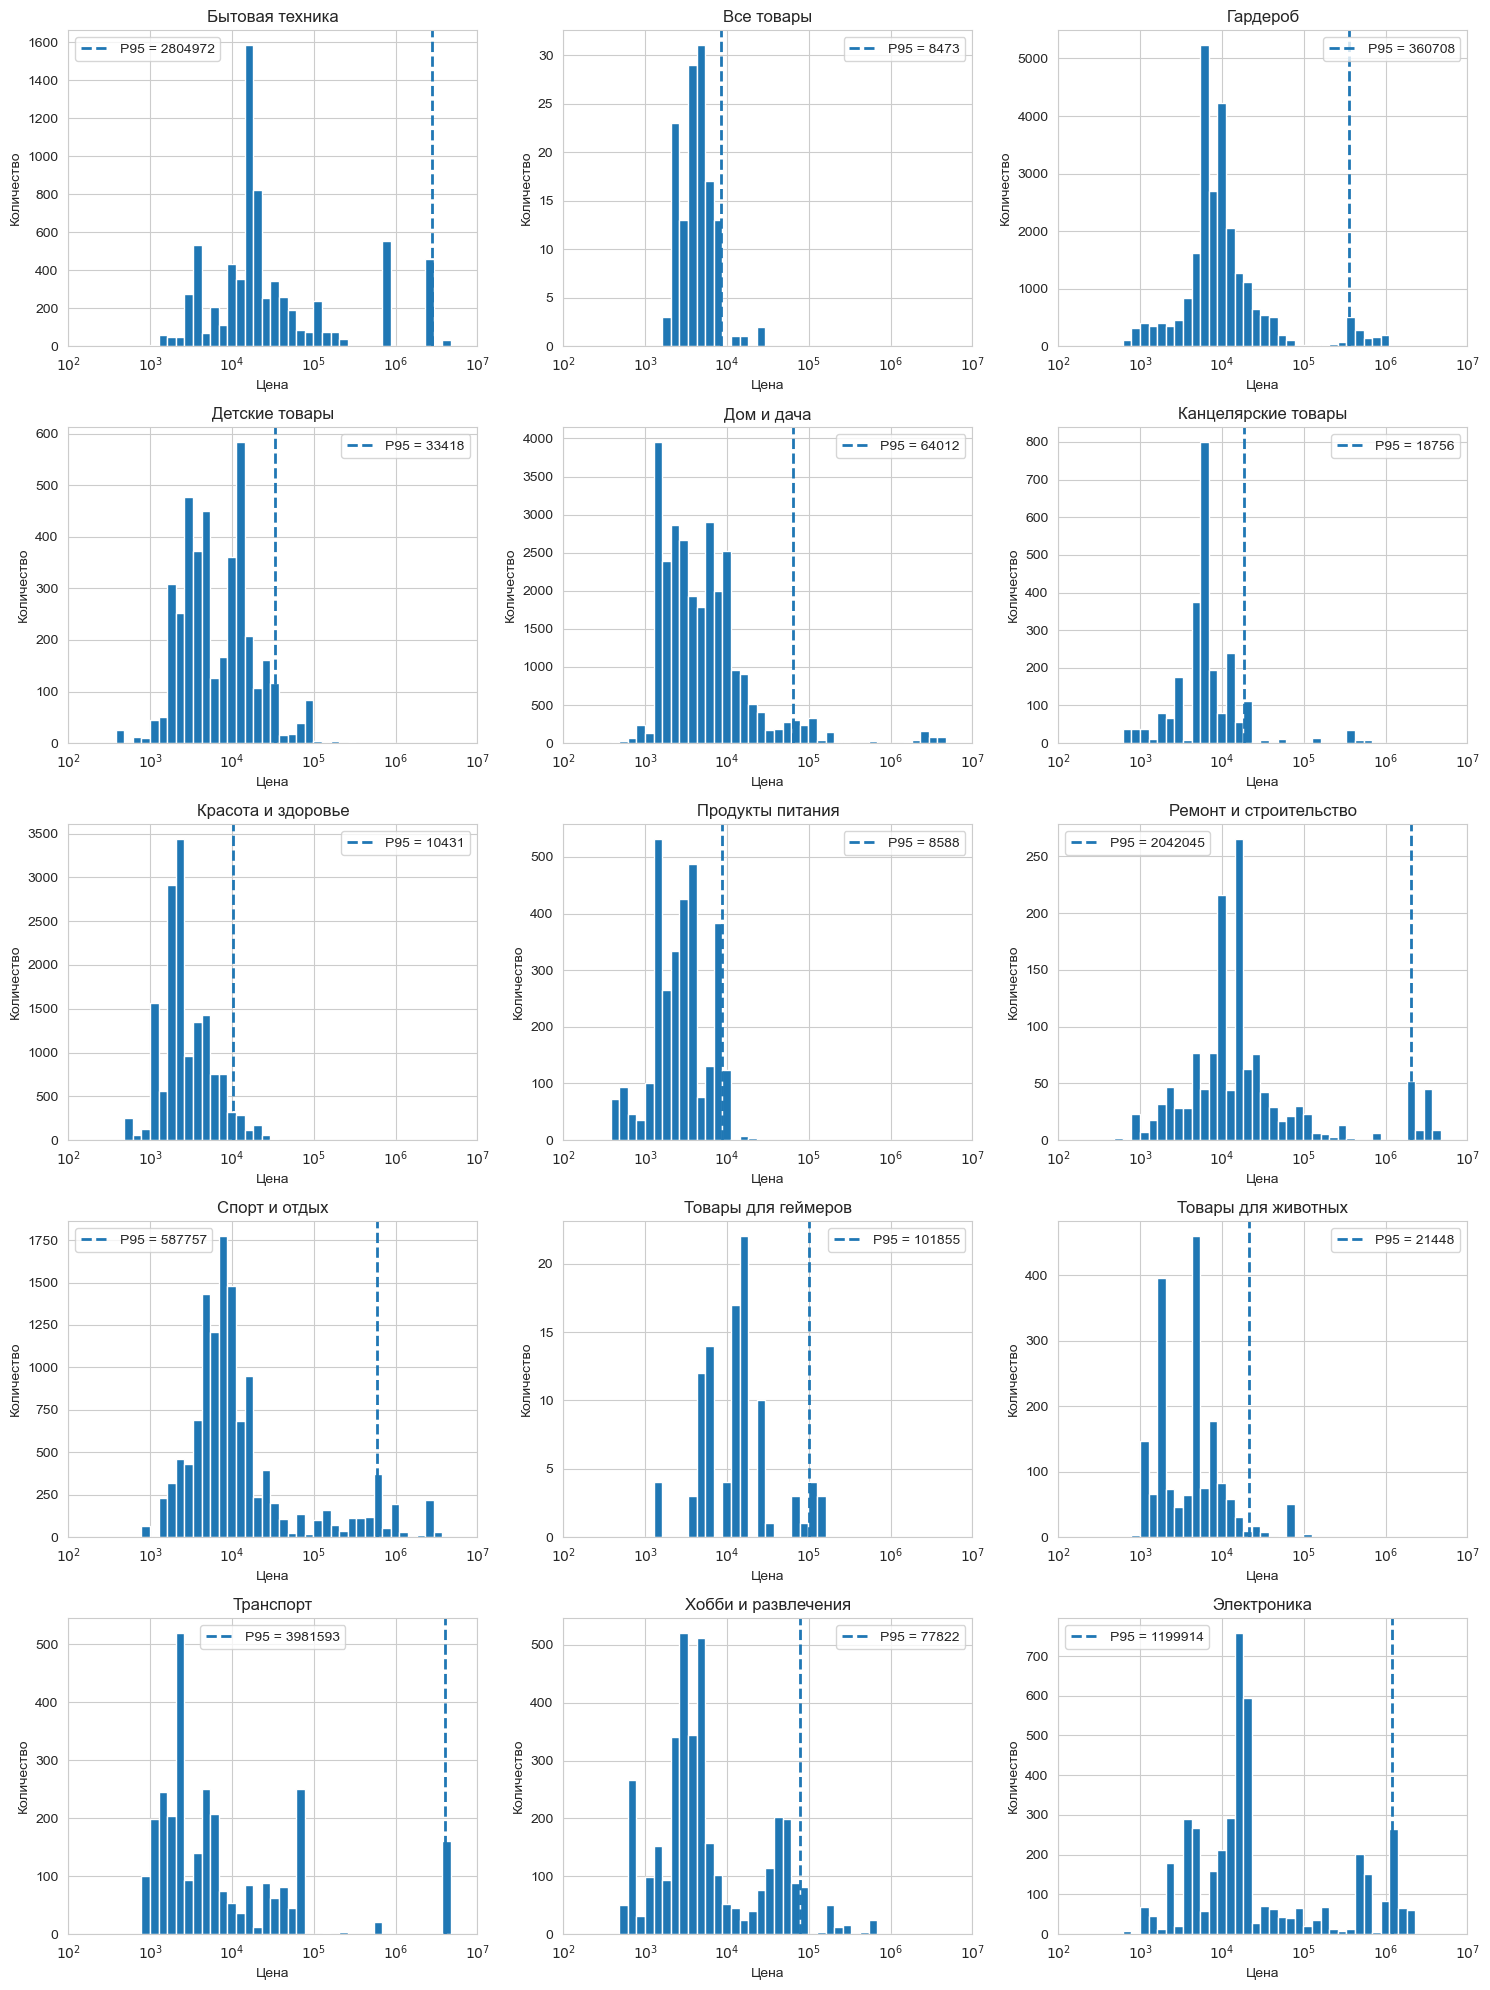

In [41]:
import numpy as np
import matplotlib.pyplot as plt


df_prices = df_full[['category', 'price']].dropna()
df_prices = df_prices[df_prices['price'] > 0]

categories = sorted(df_prices['category'].unique())
n_cat = len(categories)


n_cols = 3
n_rows = int(np.ceil(n_cat / n_cols))

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(5 * n_cols, 4 * n_rows),
    sharex=False,
    sharey=False
)

axes = axes.flatten()

# Глобальные границы цен
price_min = df_prices['price'].min()
price_max = df_prices['price'].max()

# Логарифмически равномерные бины
bins = np.logspace(
    np.log10(price_min),
    np.log10(price_max),
    40
)

log_min = int(np.floor(np.log10(price_min)))
log_max = int(np.ceil(np.log10(price_max)))
xticks = [10 ** k for k in range(log_min, log_max + 1)]

for ax, cat in zip(axes, categories):
    prices = df_prices.loc[df_prices['category'] == cat, 'price']

    ax.hist(prices, bins=bins)
    ax.set_xscale('log')

    # 95-й перцентиль
    p95 = np.percentile(prices, 95)
    ax.axvline(
        p95,
        linestyle='--',
        linewidth=2,
        label=f"P95 = {p95:.0f}"
    )

    ax.set_xticks(xticks)
    ax.set_xticklabels([f"$10^{int(np.log10(x))}$" for x in xticks])

    ax.set_title(cat)
    ax.set_xlabel("Цена")
    ax.set_ylabel("Количество")

    ax.legend()

for ax in axes[len(categories):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [65]:
# Рассчитываем 95-й перцентиль цены для каждой категории
p95_prices = df_full[df_full['price'] > 0].groupby('category')['price'].quantile(0.95).reset_index()
p95_prices.columns = ['Категория', 'P95 Цена']
p95_prices = p95_prices.sort_values('P95 Цена', ascending=False)

# Выводим список
print(p95_prices)


                 Категория     P95 Цена
12               Транспорт 3,981,593.00
0          Бытовая техника 2,804,972.00
8   Ремонт и строительство 2,042,045.00
14             Электроника 1,199,914.00
9            Спорт и отдых   587,757.00
2                 Гардероб   360,708.30
10     Товары для геймеров   101,855.00
13     Хобби и развлечения    77,822.00
4               Дом и дача    64,012.00
3           Детские товары    33,418.00
11     Товары для животных    21,447.60
5      Канцелярские товары    18,756.00
6       Красота и здоровье    10,430.60
7         Продукты питания     8,588.00
1               Все товары     8,472.60


Практически все категории имеют близкое к логнормальному распределения с длинными хвостами в сторону более дорогих вещей.

Стоит посмотреть, как распределены цены среди размещений-постов и размещений-клипов.

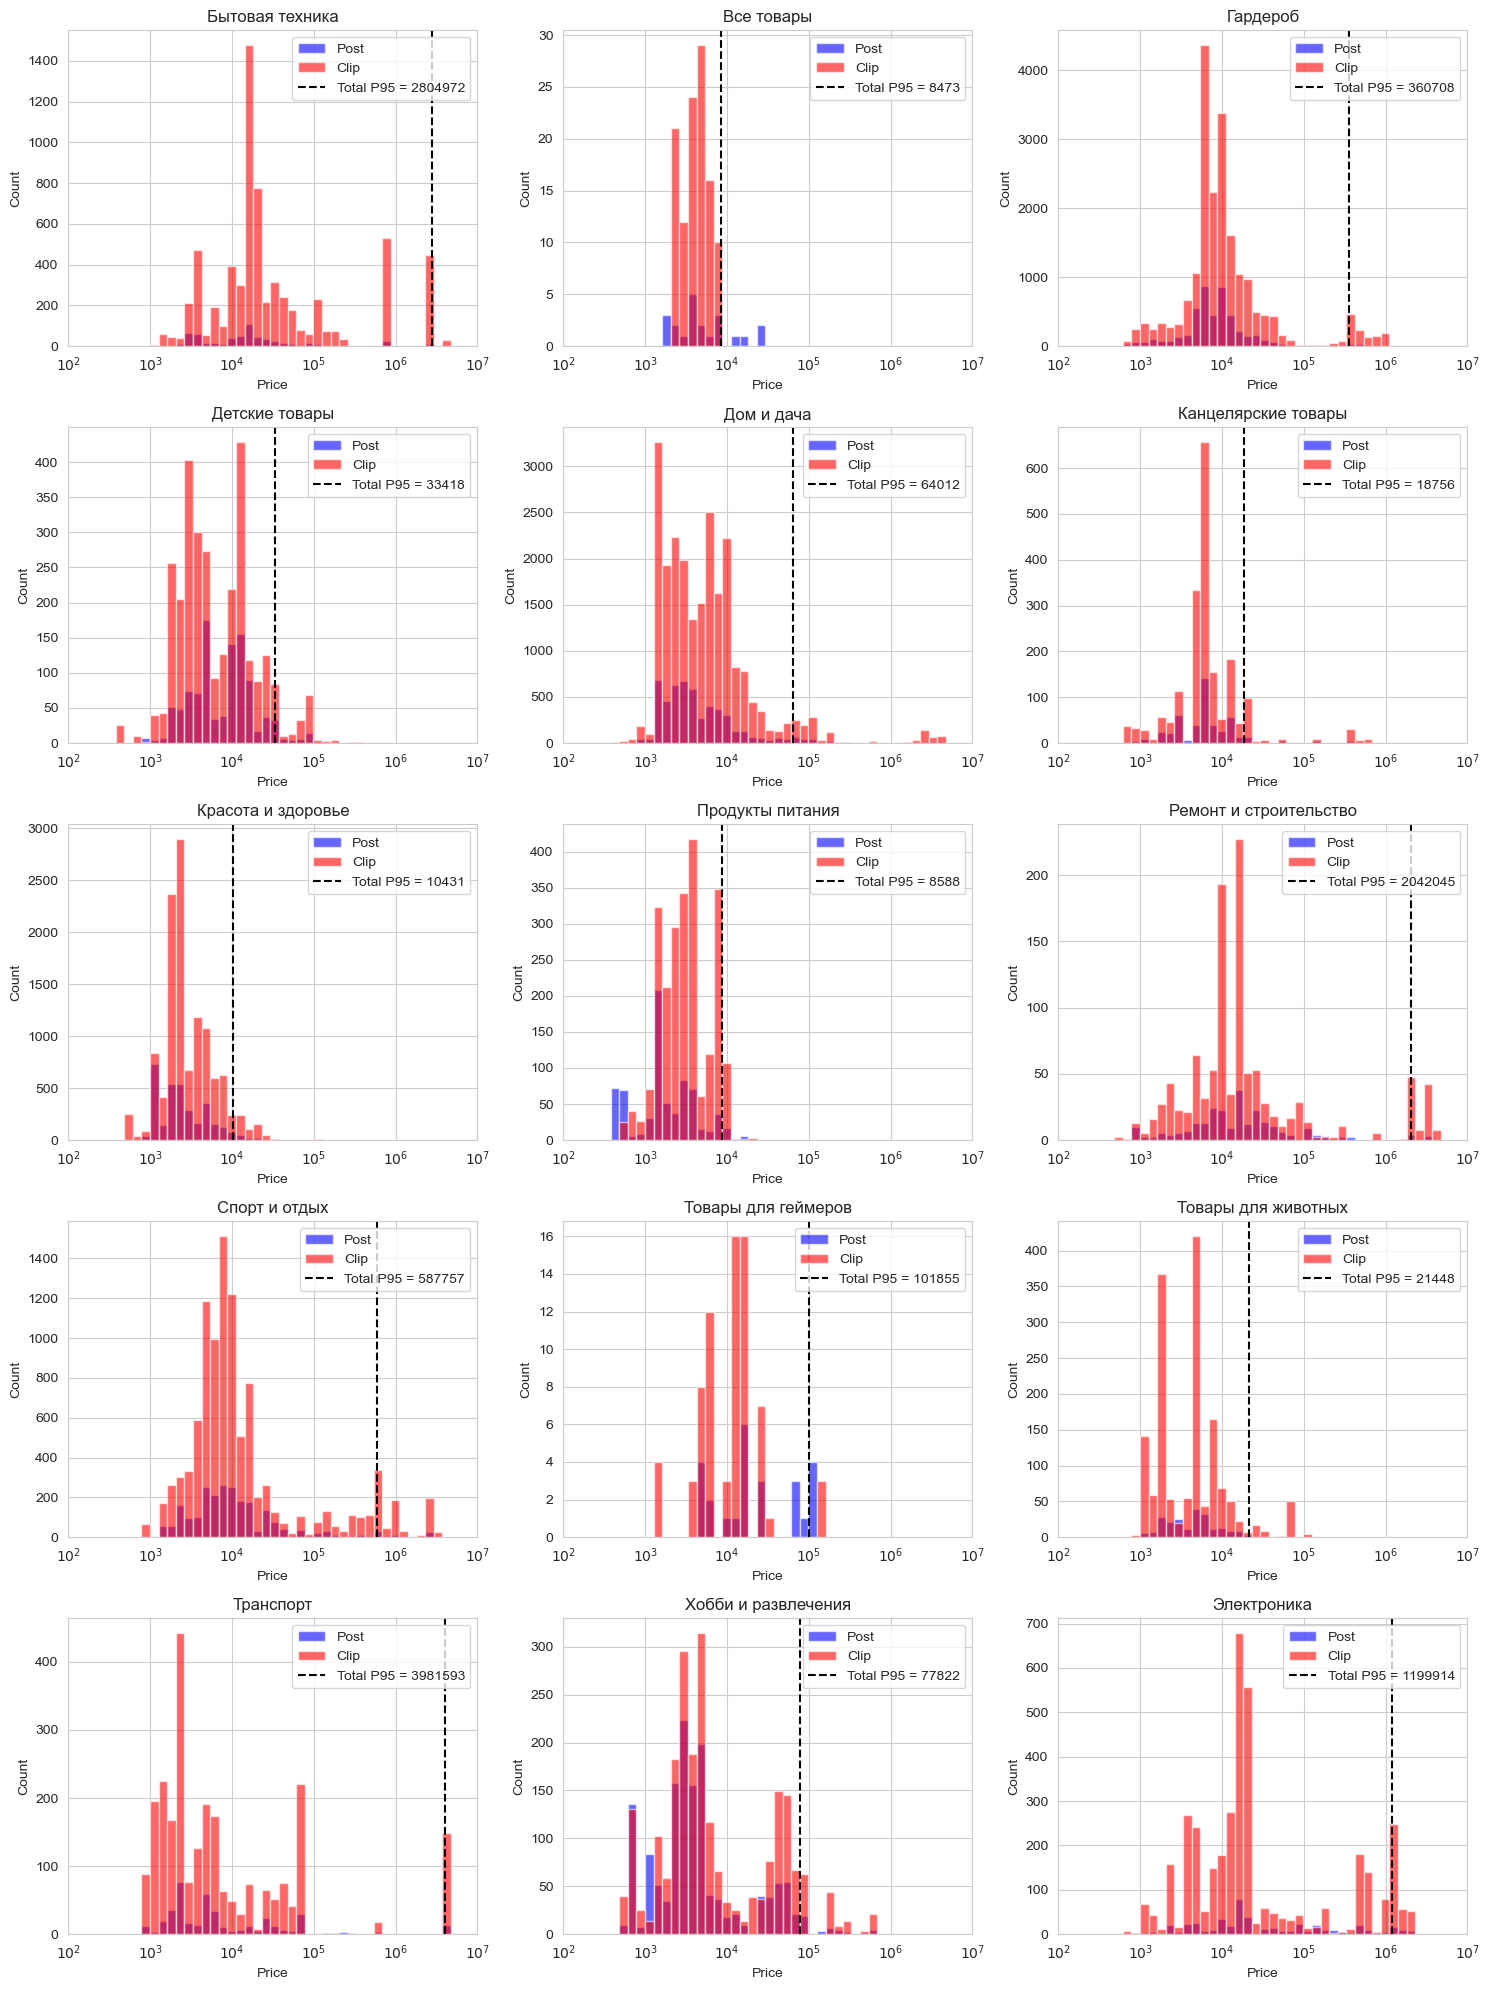

In [42]:
import numpy as np
import matplotlib.pyplot as plt


df_prices = df_full[['category', 'price', 'placement_format']].dropna()
df_prices = df_prices[df_prices['price'] > 0]

categories = sorted(df_prices['category'].unique())
n_cat = len(categories)

n_cols = 3
n_rows = int(np.ceil(n_cat / n_cols))

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(5 * n_cols, 4 * n_rows),
    sharex=False,
    sharey=False
)

axes = axes.flatten()


price_min = df_prices['price'].min()
price_max = df_prices['price'].max()


bins = np.logspace(
    np.log10(price_min),
    np.log10(price_max),
    40
)


log_min = int(np.floor(np.log10(price_min)))
log_max = int(np.ceil(np.log10(price_max)))
xticks = [10 ** k for k in range(log_min, log_max + 1)]

for ax, cat in zip(axes, categories):

    cat_data = df_prices[df_prices['category'] == cat]
    
    #Разделяем цены по типам размещений
    prices_post = cat_data.loc[cat_data['placement_format'] == 'post', 'price']
    prices_clip = cat_data.loc[cat_data['placement_format'] == 'clip', 'price']
    
   
    ax.hist(
        prices_post, 
        bins=bins, 
        color='blue', 
        alpha=0.6, 
        label='Post'
    )
    ax.hist(
        prices_clip, 
        bins=bins, 
        color='red', 
        alpha=0.6, 
        label='Clip'
    )

    ax.set_xscale('log')

   
    if not cat_data.empty:
        p95 = np.percentile(cat_data['price'], 95)
        ax.axvline(
            p95,
            linestyle='--',
            color='black',
            linewidth=1.5,
            label=f"Total P95 = {p95:.0f}"
        )

    ax.set_xticks(xticks)
    ax.set_xticklabels([f"$10^{int(np.log10(x))}$" for x in xticks])

    ax.set_title(cat)
    ax.set_xlabel("Price")
    ax.set_ylabel("Count")
    
    
    ax.legend()


for ax in axes[len(categories):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


Явных различий в распределениях цен для постов и клипов нет

А теперь посмотрим на GMV

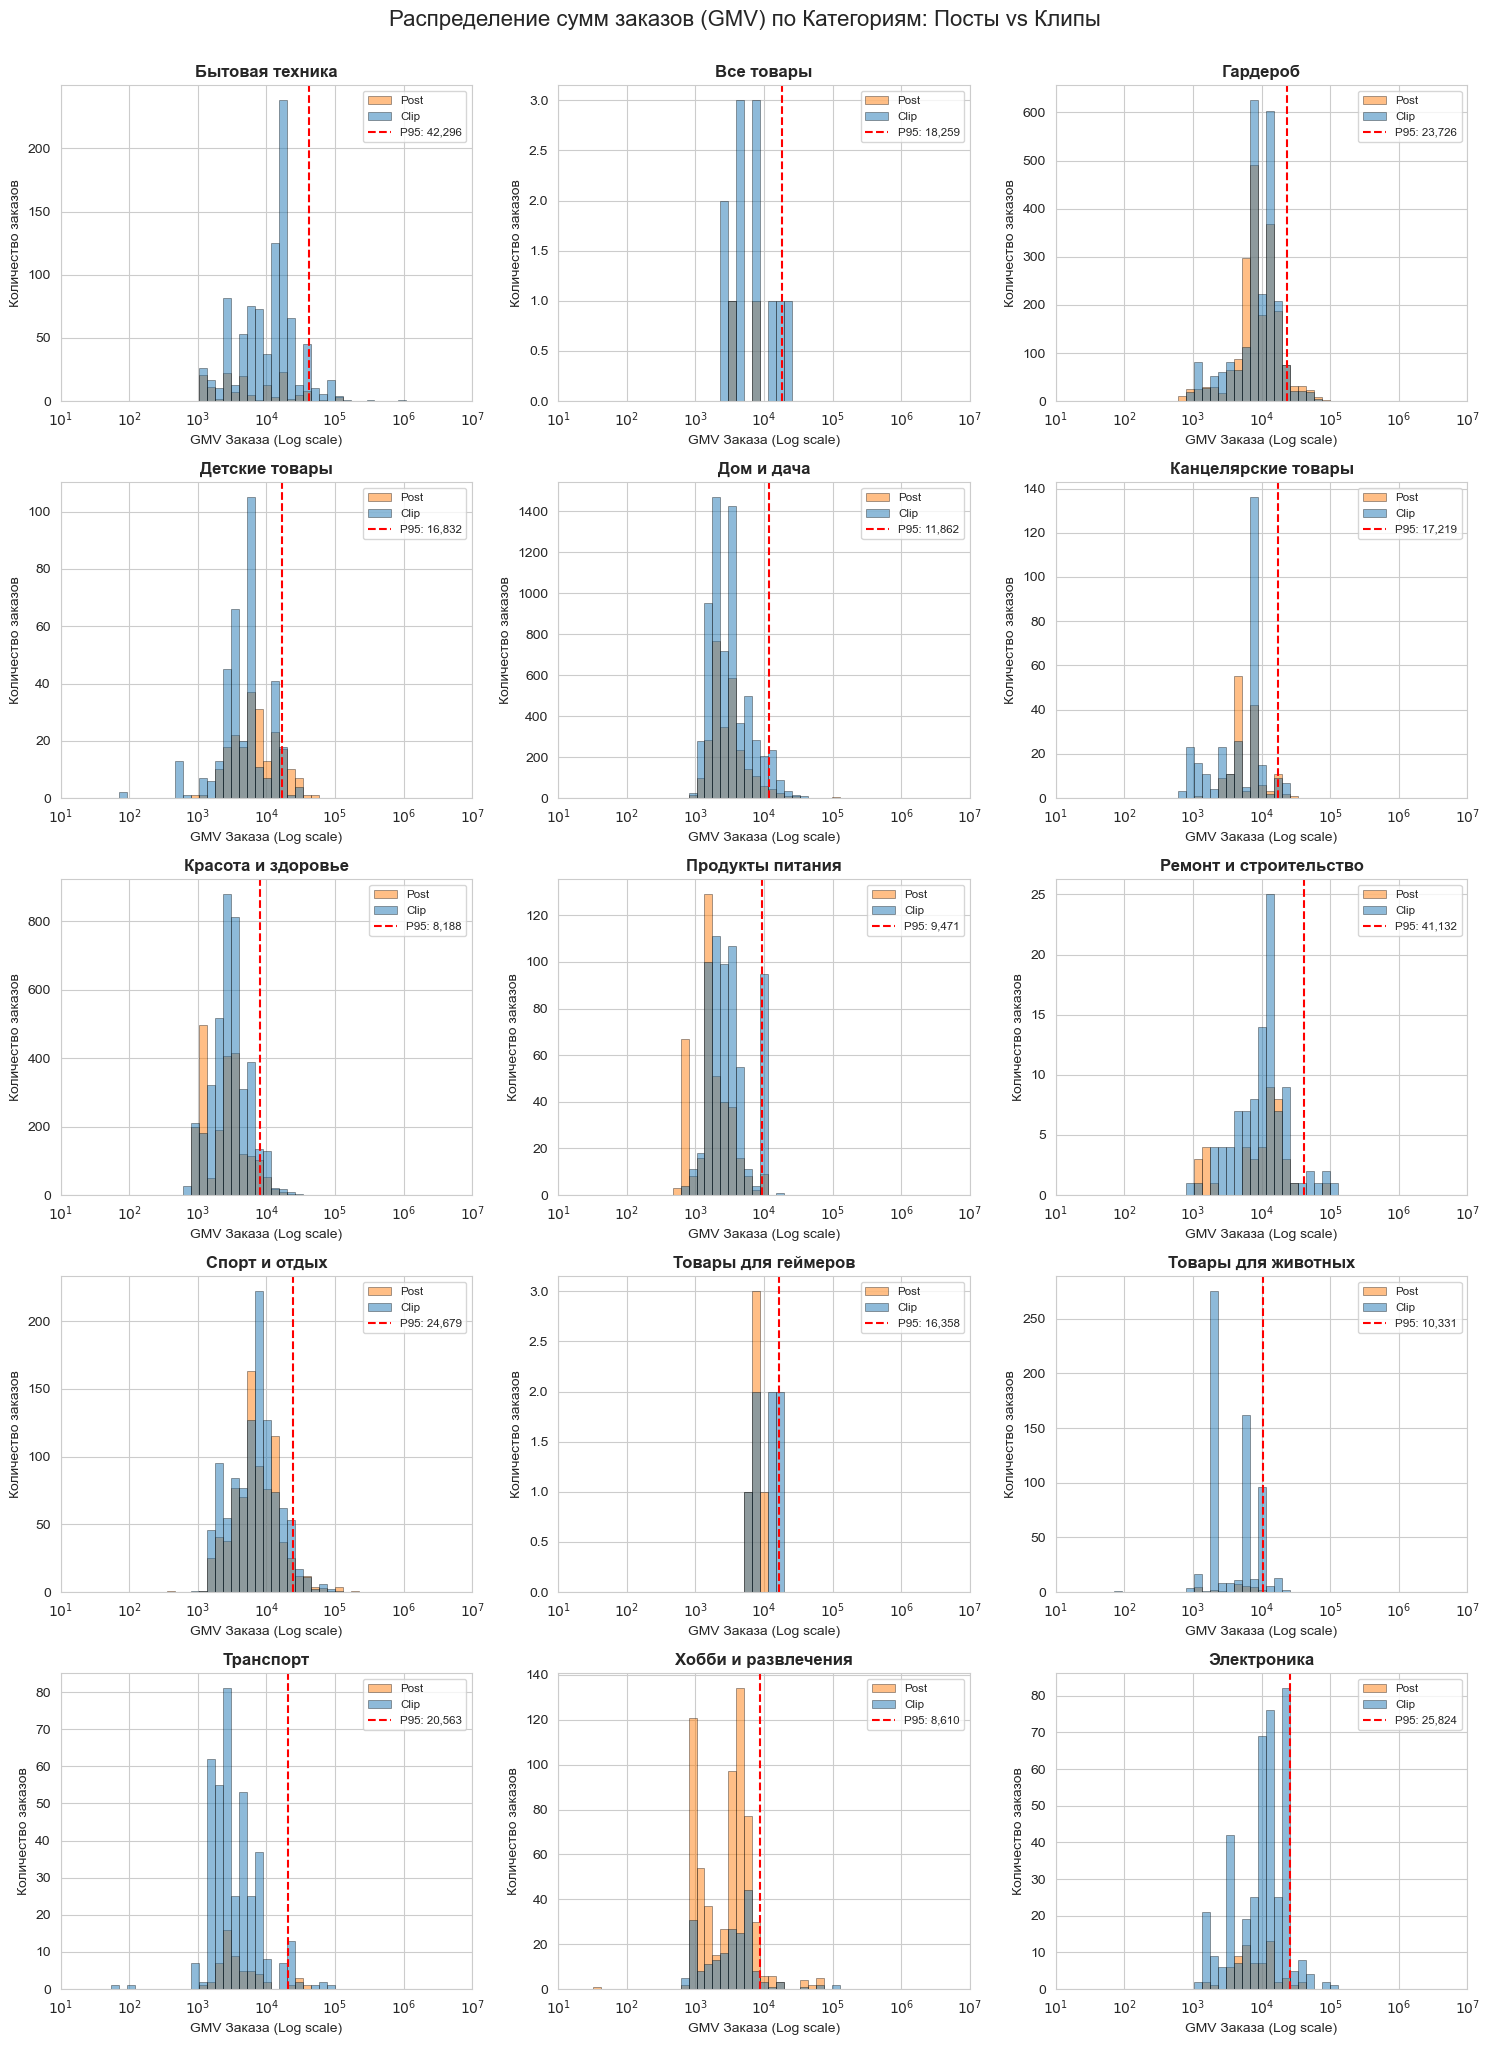

In [43]:

df_raw = df_full.dropna(subset=['hash_order_id', 'placement_format', 'GMV', 'category']).copy()
df_raw = df_raw[df_raw['GMV'] > 0]

# Группируем по ЗАКАЗАМ, сохраняя категорию и формат
df_orders = df_raw.groupby(['hash_order_id', 'placement_format', 'category'])['GMV'].sum().reset_index()

categories = sorted(df_orders['category'].unique())
n_cat = len(categories)


n_cols = 3
n_rows = int(np.ceil(n_cat / n_cols))

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(5 * n_cols, 4 * n_rows),
    sharex=False,
    sharey=False 
)
axes = axes.flatten()


gmv_min = df_orders['GMV'].min()
gmv_max = df_orders['GMV'].max()

# Логарифмические бины
bins = np.logspace(
    np.log10(gmv_min),
    np.log10(gmv_max),
    40
)


log_min = int(np.floor(np.log10(gmv_min)))
log_max = int(np.ceil(np.log10(gmv_max)))
xticks = [10 ** k for k in range(log_min, log_max + 1)]


for ax, cat in zip(axes, categories):

    cat_data = df_orders[df_orders['category'] == cat]
    
    gmv_post = cat_data.loc[cat_data['placement_format'] == 'post', 'GMV']
    gmv_clip = cat_data.loc[cat_data['placement_format'] == 'clip', 'GMV']
    

    ax.hist(gmv_post, bins=bins, color='#ff7f0e', alpha=0.5, label='Post', edgecolor='black', linewidth=0.5)
    ax.hist(gmv_clip, bins=bins, color='#1f77b4', alpha=0.5, label='Clip', edgecolor='black', linewidth=0.5)


    ax.set_xscale('log')


    if not cat_data.empty:
        p95 = np.percentile(cat_data['GMV'], 95)
        ax.axvline(
            p95,
            linestyle='--',
            color='red',
            linewidth=1.5,
            label=f"P95: {p95:,.0f}"
        )

 
    ax.set_xticks(xticks)
    ax.set_xticklabels([f"$10^{int(np.log10(x))}$" for x in xticks])
    
    ax.set_title(f"{cat}", fontsize=12, fontweight='bold')
    ax.set_xlabel("GMV Заказа (Log scale)")
    ax.set_ylabel("Количество заказов")
    
 
    if not cat_data.empty:
        ax.legend(loc='upper right', fontsize='small')


for ax in axes[len(categories):]:
    ax.axis('off')

plt.tight_layout()
plt.suptitle("Распределение сумм заказов (GMV) по Категориям: Посты vs Клипы", y=1.02, fontsize=16)
plt.show()


Для всех категорий, кроме "Хобби и развлечения", GMV клипов больше, чем для постов. 

Теперь посмотрим на временные ряды GMV в целом и по категориям

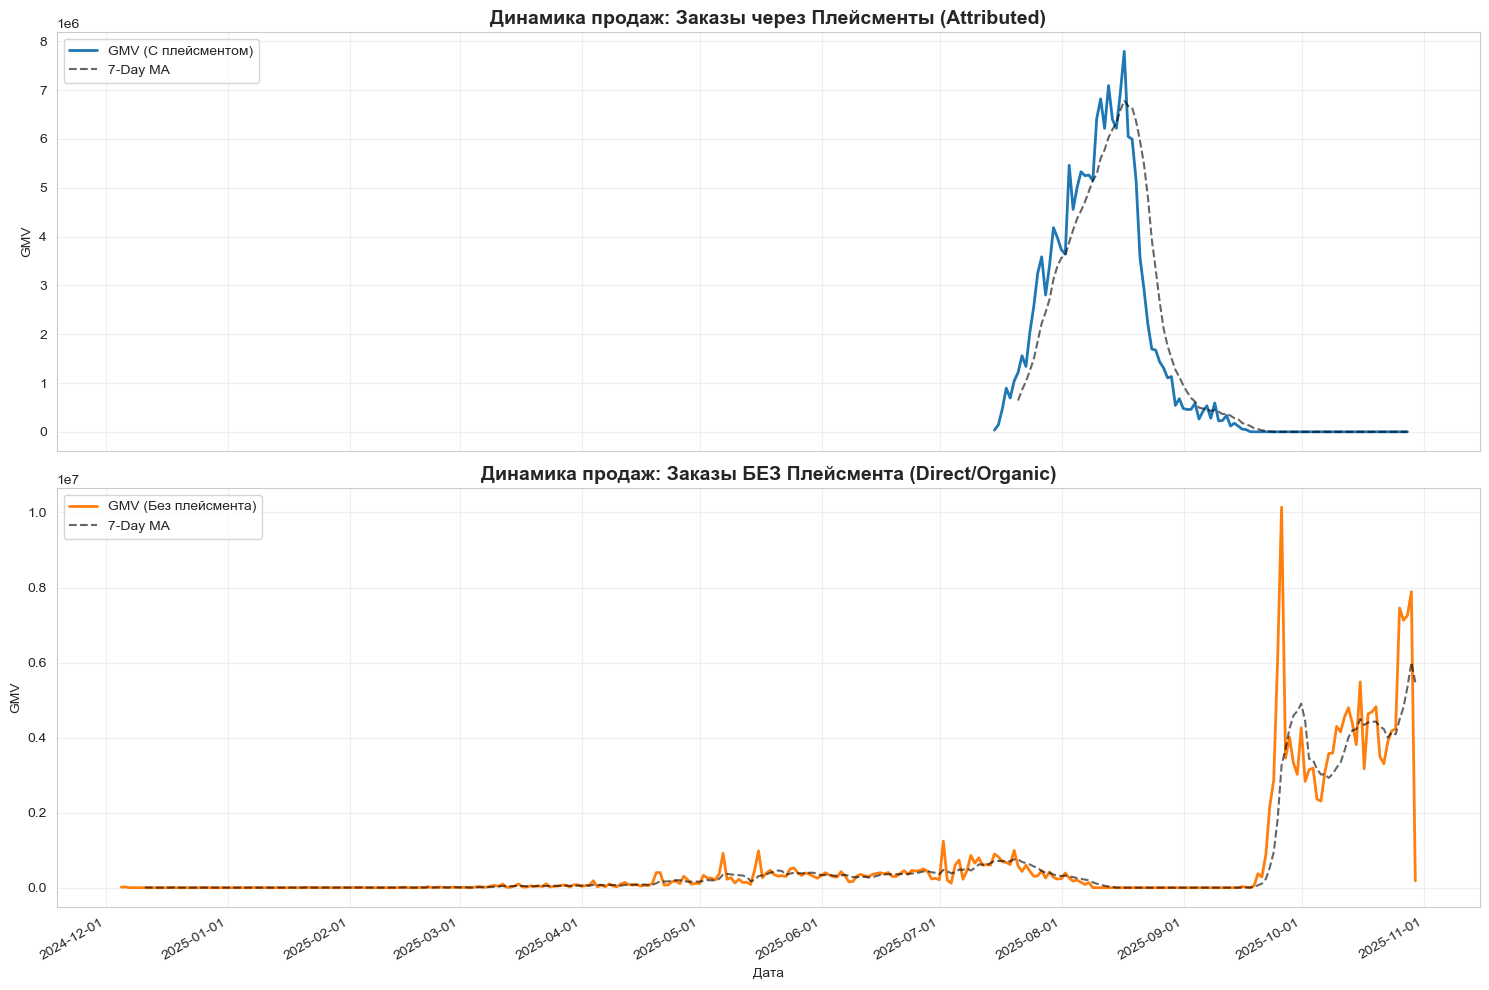

In [44]:
import matplotlib.dates as mdates


df_sales = df_full[['order_created_at', 'hash_placement_id', 'GMV']].dropna(subset=['order_created_at', 'GMV']).copy()

df_sales['order_created_at'] = pd.to_datetime(df_sales['order_created_at'])
df_sales.set_index('order_created_at', inplace=True)


sales_with_placement = df_sales[df_sales['hash_placement_id'].notna()]['GMV'].resample('D').sum()


sales_no_placement = df_sales[df_sales['hash_placement_id'].isna()]['GMV'].resample('D').sum()


fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True)

ax1 = axes[0]
ax1.plot(sales_with_placement.index, sales_with_placement.values, label='GMV (С плейсментом)', color='#1f77b4', linewidth=2) # Синий


rolling_placement = sales_with_placement.rolling(window=7).mean()
ax1.plot(rolling_placement.index, rolling_placement.values, label='7-Day MA', color='black', linestyle='--', alpha=0.6)

ax1.set_title('Динамика продаж: Заказы через Плейсменты (Attributed)', fontsize=14, fontweight='bold')
ax1.set_ylabel('GMV')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.plot(sales_no_placement.index, sales_no_placement.values, label='GMV (Без плейсмента)', color='#ff7f0e', linewidth=2) # Оранжевый


rolling_no_placement = sales_no_placement.rolling(window=7).mean()
ax2.plot(rolling_no_placement.index, rolling_no_placement.values, label='7-Day MA', color='black', linestyle='--', alpha=0.6)

ax2.set_title('Динамика продаж: Заказы БЕЗ Плейсмента (Direct/Organic)', fontsize=14, fontweight='bold')
ax2.set_ylabel('GMV')
ax2.set_xlabel('Дата')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.autofmt_xdate() 

plt.tight_layout()
plt.show()


Сложно объяснить поведение графика, не зная внутренней кухни Vk. в естественной среде "органические покупки", когда пользователь увидел товар, но купил позже через поиск, растет плавно, параллельно с платным трафиком. Тут же мы наблюдаем резкое переключение: вчера покупали только через плейсменты, спустя время - только без плейсментов. В период первой половины сентября заказов юез плейсментов вообще практически не было. Это указывает на техническую природу такого поведения графика.

Ещё будет интересно посмотреть временные ряды продаж по категориям

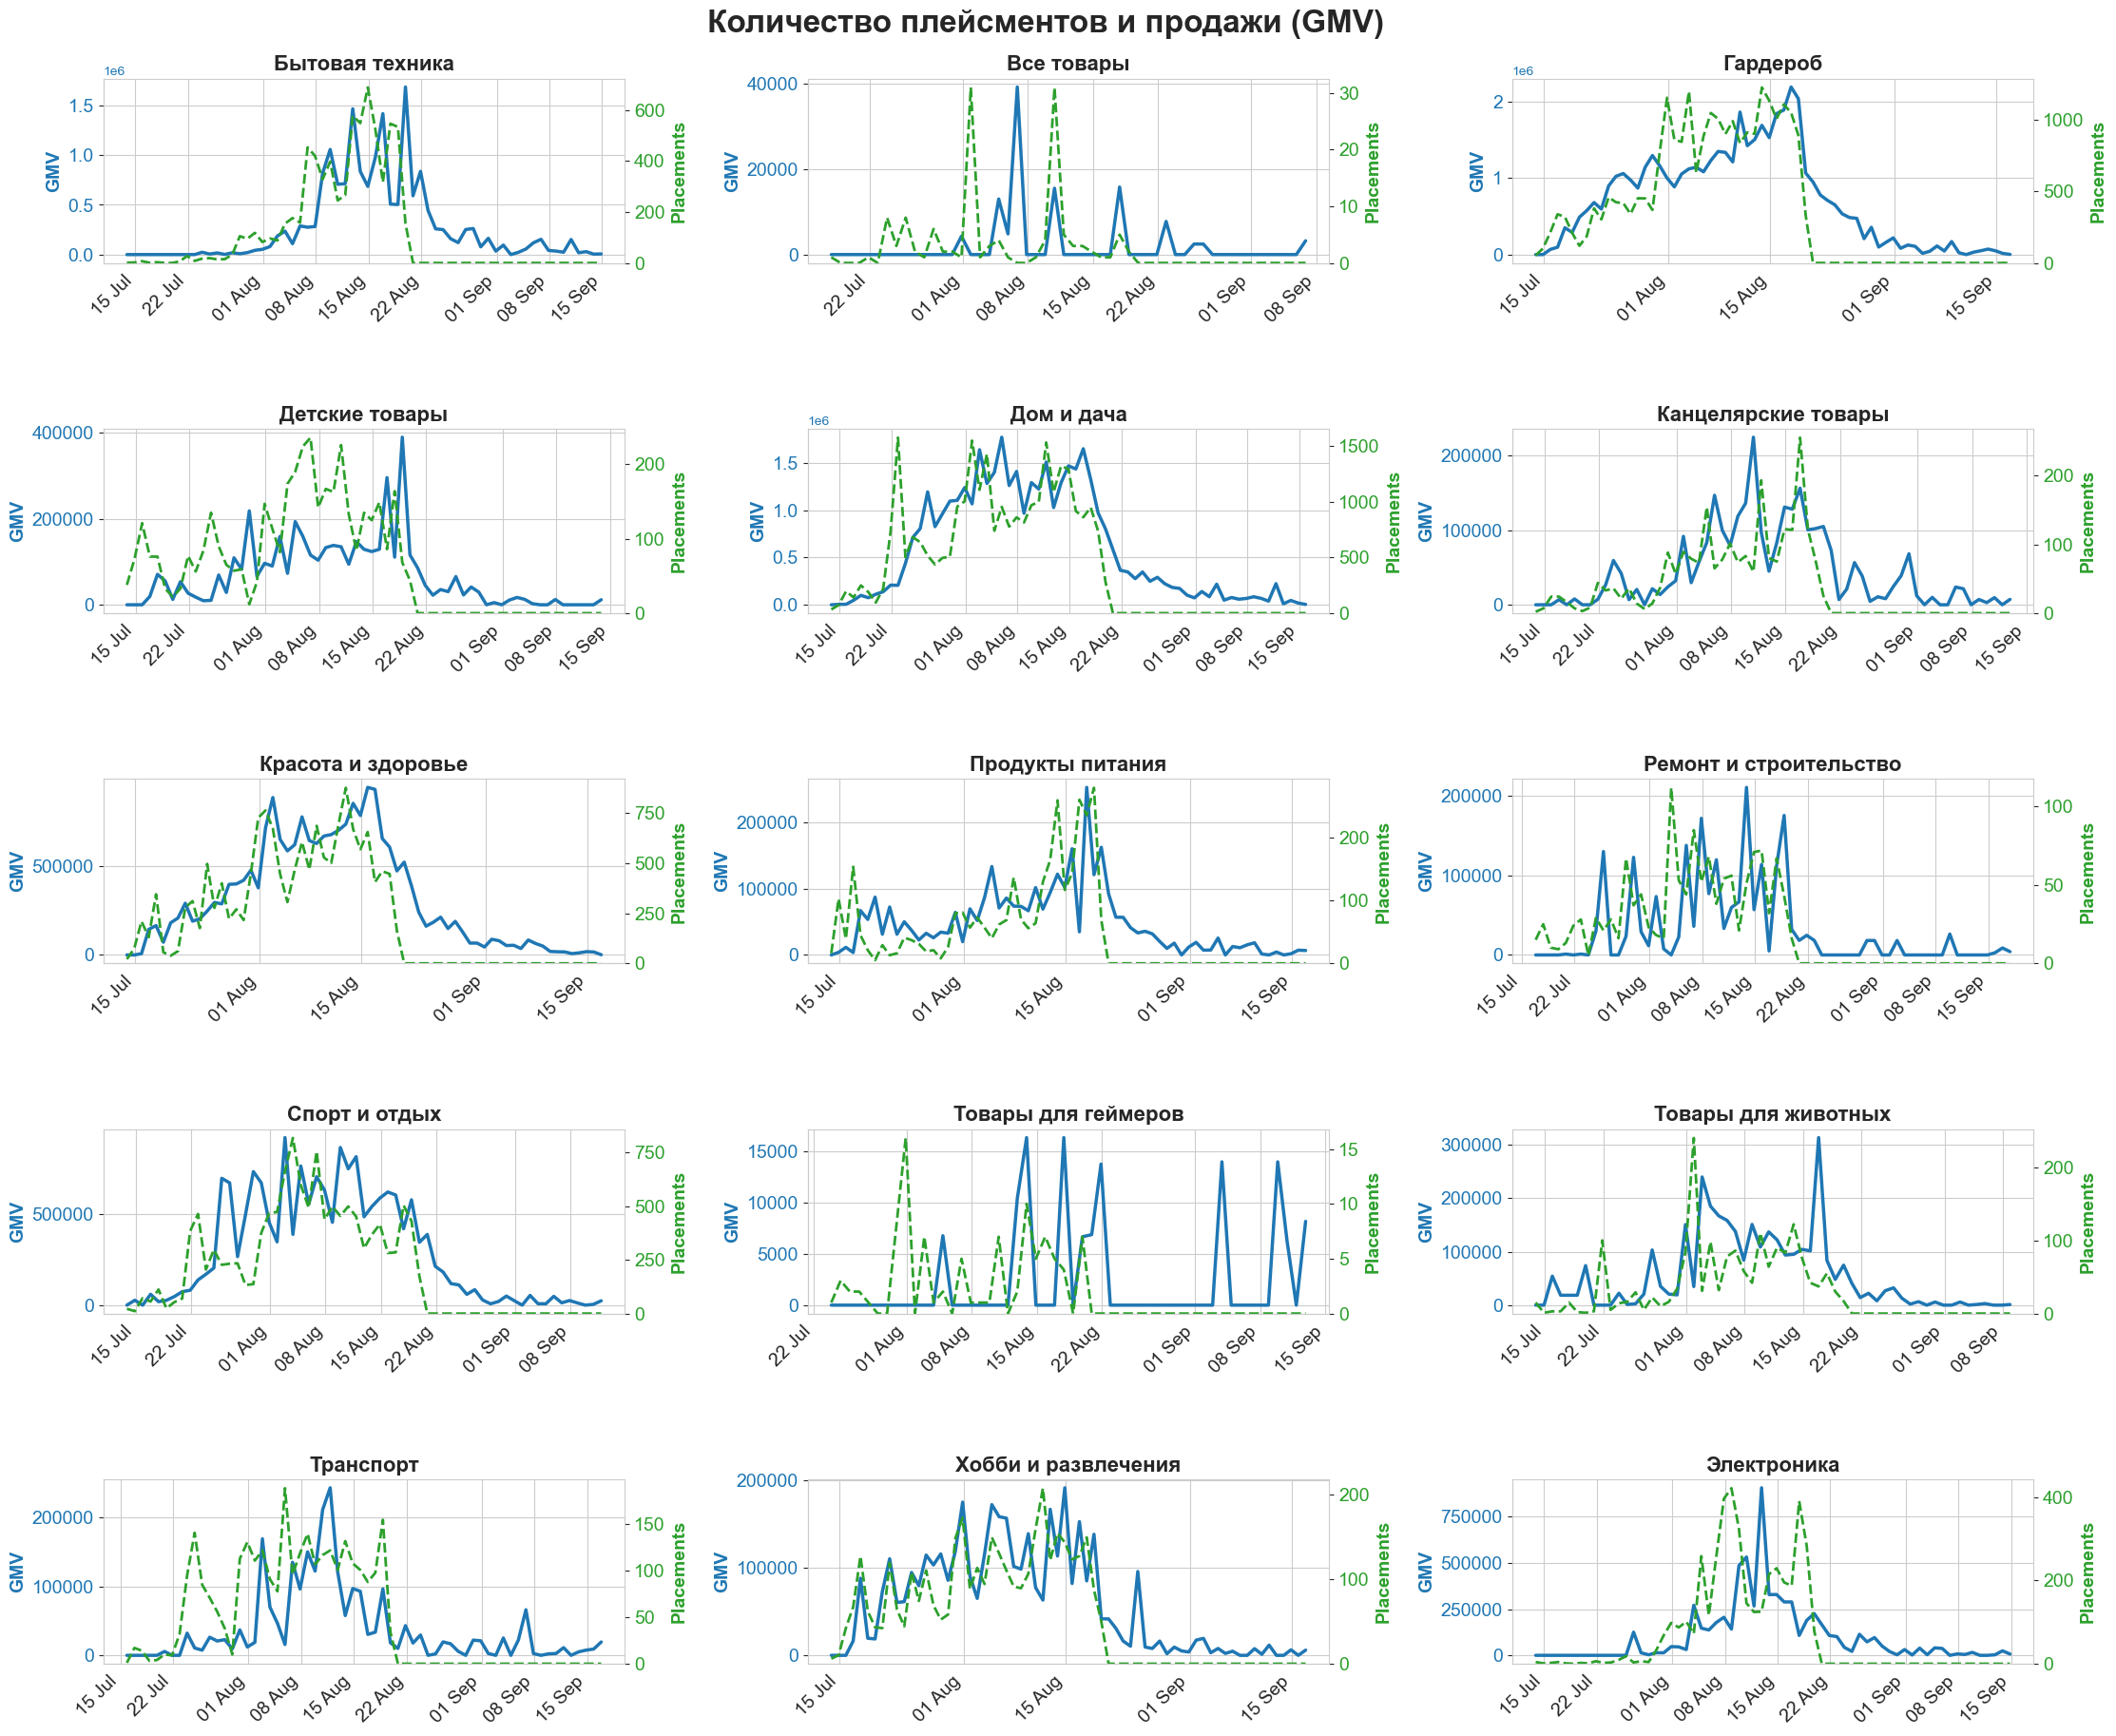

In [45]:
import seaborn as sns
import matplotlib.dates as mdates


# --- 1. Подготовка данных GMV ---
df_sales = df_full[['order_created_at', 'category', 'GMV']].dropna().copy()
df_sales['date'] = pd.to_datetime(df_sales['order_created_at']).dt.floor('D')


# Агрегация GMV
daily_sales = df_sales.groupby(['category', 'date'])['GMV'].sum().reset_index()


# --- Подготовка данных по Placements---

df_placements = df_full[['placement_created_at', 'category', 'hash_placement_id']].dropna().copy()
df_placements['date'] = pd.to_datetime(df_placements['placement_created_at']).dt.floor('D')


# Считаем количество плейсментов в день
daily_placements = df_placements.groupby(['category', 'date'])['hash_placement_id'].count().reset_index()
daily_placements.rename(columns={'hash_placement_id': 'placements_count'}, inplace=True)



df_combined = pd.merge(daily_sales, daily_placements, on=['category', 'date'], how='outer')

df_combined['GMV'] = df_combined['GMV'].fillna(0)
df_combined['placements_count'] = df_combined['placements_count'].fillna(0)


# Это лечит "странные линии": если данных нет неделю, мы создадим эти дни и поставим там 0
full_dates_list = []

for cat in df_combined['category'].unique():
    cat_data = df_combined[df_combined['category'] == cat].copy()
    
    # Создаем полный диапазон дат от начала до конца
    if cat_data.empty: continue
    min_date = cat_data['date'].min()
    max_date = cat_data['date'].max()
    all_days = pd.date_range(start=min_date, end=max_date, freq='D')
    
   
    cat_data = cat_data.set_index('date').reindex(all_days).fillna(0).reset_index()
    cat_data.rename(columns={'index': 'date'}, inplace=True)
    cat_data['category'] = cat 
    
    full_dates_list.append(cat_data)


df_final = pd.concat(full_dates_list, ignore_index=True)


sns.set_style("whitegrid")

g = sns.relplot(
    data=df_final, 
    x='date',
    y='GMV',
    col='category',
    col_wrap=3,
    kind='line',
    height=4,
    aspect=1.8,
    facet_kws={'sharey': False, 'sharex': False},
    linewidth=2.5,
    color='#1f77b4'
)

g.fig.subplots_adjust(hspace=0.9, wspace=0.35, bottom=0.15)
g.fig.suptitle('Количество плейсментов и продажи (GMV)', y=1.02, fontsize=24, fontweight='bold')
g.set_titles("{col_name}", size=16, fontweight='bold')
g.set_axis_labels("", "")

for ax in g.axes.flat:
    category_name = ax.get_title()
    subset = df_final[df_final['category'] == category_name]
    
    # ЛЕВАЯ ОСЬ (GMV)
    ax.set_ylabel('GMV', color='#1f77b4', fontsize=14, fontweight='bold')
    ax.tick_params(axis='y', labelcolor='#1f77b4', labelsize=14)
    
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=14)

    # ПРАВАЯ ОСЬ (Placements)
    ax2 = ax.twinx()
    
    
    ax2.plot(subset['date'], subset['placements_count'], color='#2ca02c', linewidth=2, linestyle='--', label='Placements')
    
    ax2.set_ylabel('Placements', color='#2ca02c', fontsize=14, fontweight='bold')
    ax2.tick_params(axis='y', labelcolor='#2ca02c', labelsize=14)
    ax2.grid(False)
    

    ax2.set_ylim(bottom=0) 

plt.show()


Из временных рядов продаж видно, что рекламные размещения перестали публиковаться во второй половине августа. Скорее всего это связано с окончанием эксперимента.

Теперь посмотрим на воронку продаж

In [46]:

import plotly.graph_objects as go
from plotly.subplots import make_subplots



#Считаем Просмотры и Клики
df_placements_unique = df_full.drop_duplicates(subset=['hash_placement_id']).copy()
funnel_top = df_placements_unique.groupby('category')[['views', 'clicks']].sum().reset_index()

#Считаем Заказы
df_orders = df_full.dropna(subset=['hash_order_id', 'order_status_code']).copy()

# Приводим статус к строке
df_orders['order_status_code'] = df_orders['order_status_code'].astype(str).str.replace(r'\.0$', '', regex=True)

# Считаем уникальные заказы
orders_total = df_orders.groupby('category')['hash_order_id'].nunique().reset_index(name='orders_created')

# Считаем завершеные
orders_completed = df_orders[df_orders['order_status_code'] == '5'].groupby('category')['hash_order_id'].nunique().reset_index(name='orders_completed')



# Объединяем Просмотры/Клики + Заказы Всего + Завершенные
funnel_df = funnel_top
for df_part in [orders_total, orders_completed]:
    if funnel_df.empty:
        funnel_df = df_part
    else:
        funnel_df = funnel_df.merge(df_part, on='category', how='outer')

funnel_df = funnel_df.fillna(0)


categories = funnel_df['category'].unique()
categories = [c for c in categories if funnel_df[funnel_df['category'] == c].iloc[0, 1:].sum() > 0]


cols = 2
rows = (len(categories) // cols) + (1 if len(categories) % cols > 0 else 0)

fig = make_subplots(
    rows=rows, cols=cols, 
    subplot_titles=categories,
    specs=[[{"type": "funnel"}] * cols] * rows,
    vertical_spacing=0.08,  
    horizontal_spacing=0.15 
)

row_i = 1
col_i = 1
stages = ['Просмотры', 'Клики', 'Заказы', 'Завершены']

for cat in categories:
    data = funnel_df[funnel_df['category'] == cat].iloc[0]
    
    real_values = [
        data.get('views', 0), 
        data.get('clicks', 0), 
        data.get('orders_created', 0), 
        data.get('orders_completed', 0)
    ]
    
    log_values = [np.log10(v + 1) if v > 0 else 0 for v in real_values]
    

    
    text_labels = []
    for i, val in enumerate(real_values):
        val_str = f"{val:,.0f}"
        
        if i > 0 and real_values[i-1] > 0:
            pct = (val / real_values[i-1]) * 100
            
            if pct < 0.01:
                
                pct_str = f"{pct:.3f}%"
            elif pct < 1:
               
                pct_str = f"{pct:.3f}%"
            else:
                
                pct_str = f"{pct:.1f}%"
            
        elif i > 0:
            pct_str = "0%"
        else:
            pct_str = "100%"
        
        text_labels.append(f"<b>{val_str}</b><br><span style='font-size:11px'>({pct_str})</span>")


    fig.add_trace(go.Funnel(
        name=str(cat),
        y=stages,
        x=log_values,
        text=text_labels,
        textinfo="text",
        textposition="inside",
        textfont=dict(size=14, color="white"), 
        marker={"color": ["#1f77b4", "#ff7f0e", "#2ca02c", "#9467bd"]},
        connector={"line": {"color": "rgba(255,255,255,0.5)", "width": 1}}
    ), row=row_i, col=col_i)
    
    col_i += 1
    if col_i > cols:
        col_i = 1
        row_i += 1


total_height = 400 * rows

fig.update_layout(
    title_text="Воронка продаж",
    title_x=0.5,
    title_font_size=24,
    height=total_height,
    showlegend=False,
    font=dict(size=12)
)

fig.show()


Давайте от глобальных метрик перейдём к метрикам по размещениям. Посмотрим на средний GMV, количество офферов рекламодателей и охваты аудитории для постов и клипов отдельно.

In [ ]:
df_clean = df_full.dropna(subset=['placement_format', 'category']).copy()

# --- Среднее количество просмотров на размещение ---
# Нам нужны уникальные плейсменты, чтобы просмотры не дублировались
df_placements = df_clean.drop_duplicates(subset=['hash_placement_id'])

avg_views = df_placements.groupby(['category', 'placement_format'])['views'].mean().reset_index(name='avg_views_per_placement')


# --- Количество офферов ---
# Считаем уникальные ID офферов
offers_count = df_clean.groupby(['category', 'placement_format'])['hash_offer_id'].nunique().reset_index(name='offers_count')


# --- Средний GMV на один плейсмент Важно: мы считаем среднее только по тем плейсментам, которые принесли ХОТЬ КАКИЕ-ТО деньги. ---
df_orders = df_clean.dropna(subset=['hash_order_id', 'GMV'])
df_orders = df_orders[df_orders['GMV'] > 0]


gmv_per_placement = df_orders.groupby(['hash_placement_id', 'category', 'placement_format'])['GMV'].sum().reset_index()

avg_gmv_placement = gmv_per_placement.groupby(['category', 'placement_format'])['GMV'].mean().reset_index(name='avg_gmv_per_selling_placement')



result = avg_views.merge(offers_count, on=['category', 'placement_format'], how='outer')
result = result.merge(avg_gmv_placement, on=['category', 'placement_format'], how='outer')


result = result.fillna(0)


result = result.sort_values(['category', 'placement_format'])


pd.options.display.float_format = '{:,.2f}'.format


result.columns = ['Категория', 'Формат', 'Средние просмотры', 'Кол-во офферов', 'Средний GMV (с продающего плейсмента)']

result




,Категория,Формат,Средние просмотры,Кол-во офферов,Средний GMV (с продающего плейсмента)
0,Бытовая техника,clip,"35,901.67",572,"38,539.66"
1,Бытовая техника,post,"28,570.01",229,"27,402.92"
2,Все товары,clip,"28,620.55",55,"10,873.44"
3,Все товары,post,"41,607.21",18,"10,869.00"
4,Гардероб,clip,"31,397.09",5851,"23,603.78"
5,Гардероб,post,"61,522.56",2044,"43,976.10"
6,Детские товары,clip,"36,075.92",821,"14,050.75"
7,Детские товары,post,"42,498.50",446,"18,885.13"
8,Дом и дача,clip,"32,894.45",3939,"16,042.91"
9,Дом и дача,post,"45,245.99",1621,"20,792.81"


In [64]:

gmv_comparison = result.pivot(index='Категория', columns='Формат', values='Средний GMV (с продающего плейсмента)')

gmv_comparison = gmv_comparison.fillna(0)

clips_winners = gmv_comparison[gmv_comparison['clip'] > gmv_comparison['post']].index.tolist()


posts_winners = gmv_comparison[gmv_comparison['post'] > gmv_comparison['clip']].index.tolist()


print(f"=== Категории, где КЛИПЫ (Clips) приносят больше GMV ({len(clips_winners)}) ===")
for cat in clips_winners:
    diff = gmv_comparison.loc[cat, 'clip'] - gmv_comparison.loc[cat, 'post']
    print(f"- {cat} (Разница: +{diff:,.0f} ₽)")

print("\n" + "="*60 + "\n")

print(f"=== Категории, где ПОСТЫ (Posts) приносят больше GMV ({len(posts_winners)}) ===")
for cat in posts_winners:
    diff = gmv_comparison.loc[cat, 'post'] - gmv_comparison.loc[cat, 'clip']
    print(f"- {cat} (Разница: +{diff:,.0f} ₽)")


=== Категории, где КЛИПЫ (Clips) приносят больше GMV (7) ===
- Бытовая техника (Разница: +11,137 ₽)
- Все товары (Разница: +4 ₽)
- Продукты питания (Разница: +2,788 ₽)
- Ремонт и строительство (Разница: +1,657 ₽)
- Товары для животных (Разница: +19,673 ₽)
- Транспорт (Разница: +2,556 ₽)
- Электроника (Разница: +15,856 ₽)


=== Категории, где ПОСТЫ (Posts) приносят больше GMV (8) ===
- Гардероб (Разница: +20,372 ₽)
- Детские товары (Разница: +4,834 ₽)
- Дом и дача (Разница: +4,750 ₽)
- Канцелярские товары (Разница: +4,216 ₽)
- Красота и здоровье (Разница: +8,636 ₽)
- Спорт и отдых (Разница: +13,693 ₽)
- Товары для геймеров (Разница: +2,489 ₽)
- Хобби и развлечения (Разница: +3,863 ₽)


Как видно из воронки продаж, главный лимитирующий этап - это конверсия просмотров в клики. CTR на уровне десятых долей процента. Давайте посмотрим CTR для каждой категории отдельно для постов и клипов.

In [47]:
df_metrics = df_full.dropna(subset=['placement_format', 'hash_placement_id', 'views', 'clicks']).copy()
df_ctr=df_metrics.groupby(['category', 'placement_format'])[['views', 'clicks']].sum().reset_index()
df_ctr['CTR_%']=df_ctr['clicks']/df_ctr['views']*100

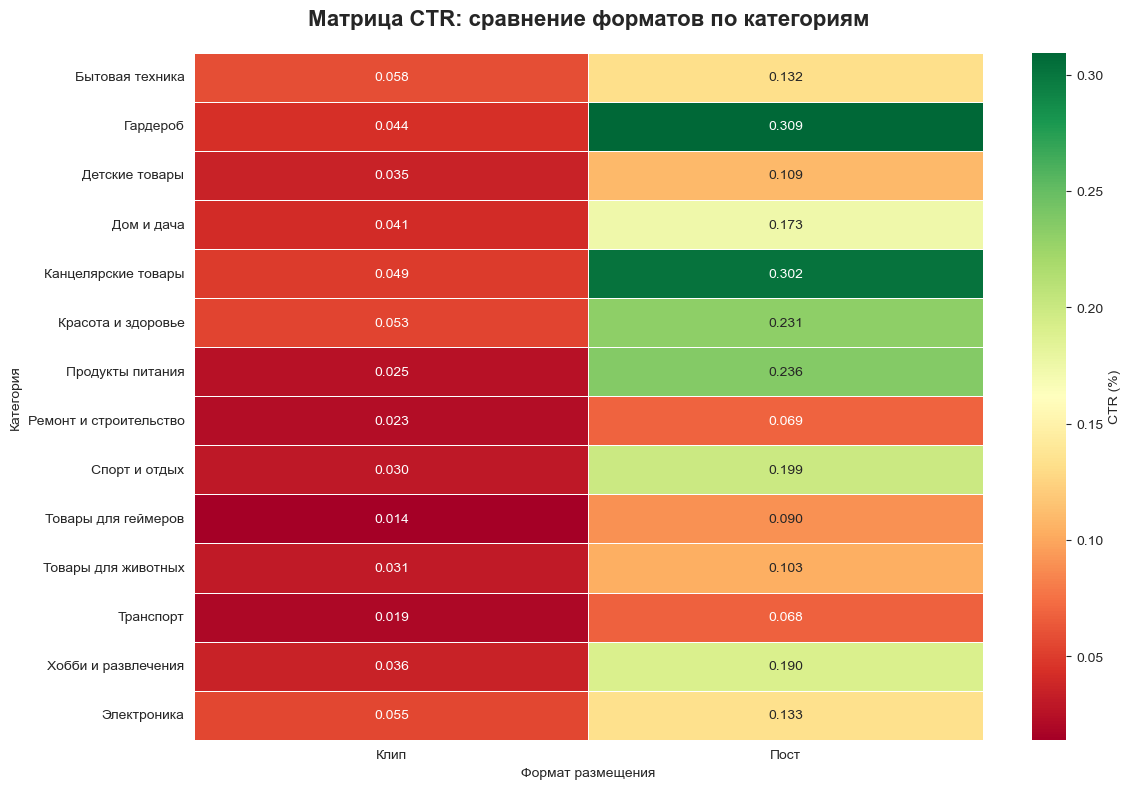

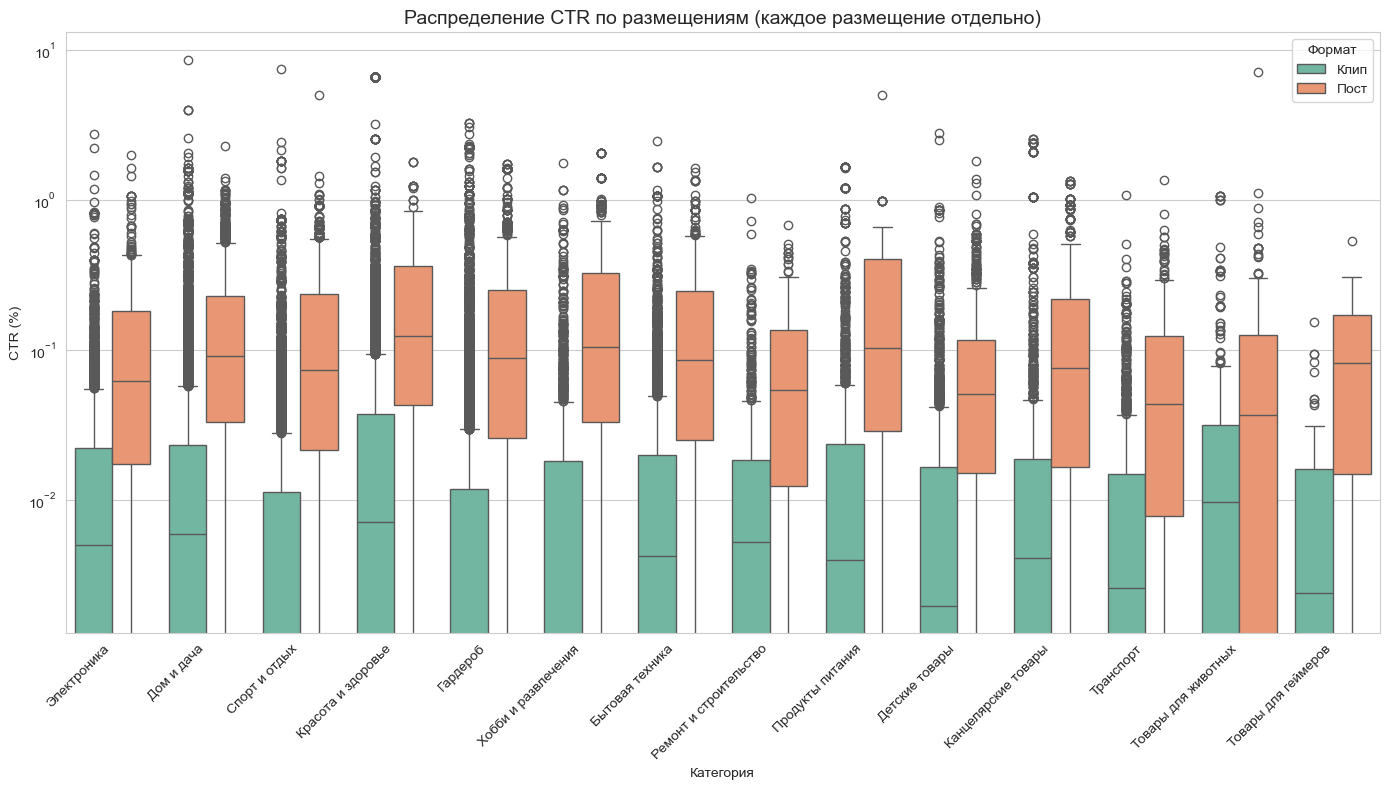

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

#(убираем "Все товары")
df_plot = df_ctr[df_ctr['category'] != 'Все товары'].copy()
df_plot['placement_format'] = df_plot['placement_format'].replace({'clip': 'Клип', 'post': 'Пост'})


# Тепловая карта 
plt.figure(figsize=(12, 8))
pivot_ctr = df_plot.pivot(index='category', columns='placement_format', values='CTR_%')

sns.heatmap(pivot_ctr, annot=True, fmt='.3f', cmap='RdYlGn', 
            cbar_kws={'label': 'CTR (%)'}, linewidths=0.5)
plt.title('Матрица CTR: сравнение форматов по категориям', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Категория')
plt.xlabel('Формат размещения')
plt.tight_layout()
plt.show()

# CTR для каждого размещения
df_metrics['CTR_%'] = df_metrics['clicks'] / df_metrics['views'] * 100

plt.figure(figsize=(14, 8))
df_box = df_metrics[df_metrics['category'] != 'Все товары'].copy()
df_box['placement_format'] = df_box['placement_format'].replace({'clip': 'Клип', 'post': 'Пост'})

sns.boxplot(data=df_box, x='category', y='CTR_%', hue='placement_format', 
            palette='Set2')
plt.title('Распределение CTR по размещениям (каждое размещение отдельно)', fontsize=14)


plt.xticks(rotation=45, ha='right')
plt.ylabel('CTR (%)')
plt.xlabel('Категория')
plt.legend(title='Формат')
plt.yscale('log')  # Логарифмическая шкала — CTR сильно скошены
plt.tight_layout()
plt.show()





Посты доминируют по CTR во всех категориях (в 2-5 раз выше).

У постов медианный CTR по всем категориям заметно выше, чем у клипов (оранжевые выше зелёных). В среднем посты кликают чаще, чем клипы при тех же просмотрах.

У клипов почти весь CTR около нуля, boxplot для них малоинформативен: лог‑шкала растягивает значения и забивает график, а форма распределения не читается.

Поэтому построим Boxplot только для постов

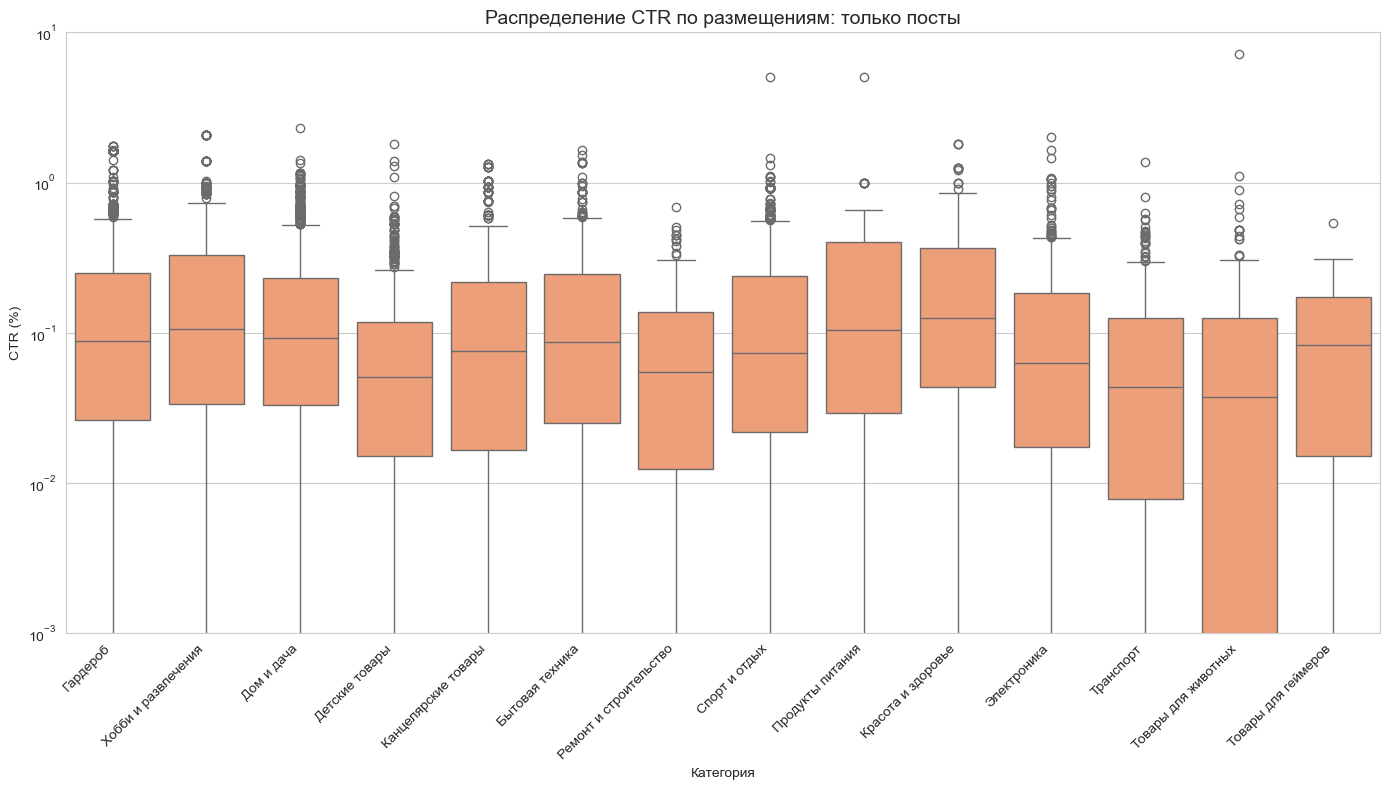

In [49]:

df_metrics['CTR_%'] = df_metrics['clicks'] / df_metrics['views'] * 100

# только посты
df_box_post = df_metrics[
    (df_metrics['placement_format'] == 'post') &
    (df_metrics['category'] != 'Все товары')
].copy()

plt.figure(figsize=(14, 8))
sns.boxplot(
    data=df_box_post,
    x='category',
    y='CTR_%',
    color='#ff9966'
)

plt.title('Распределение CTR по размещениям: только посты', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylabel('CTR (%)')
plt.xlabel('Категория')

plt.yscale('log')         
plt.ylim(0.001, 10)       

plt.tight_layout()
plt.show()


Отдельные точки высоко над коробками - размещения‑«ракеты» с аномально высоким CTR. На них стоит смотреть отдельно (кто автор, какой креатив, какой оффер), это кандидаты в «best practices». С помощью таких авторов и размещений можно создавать методику-рекомендации по выпуску хитовых постов.

Давайте теперь посмотрим топ категорий с наилучшей наградой для автора

In [50]:
# --- Агрегация ПРОСМОТРОВ, КЛИКОВ и ВОЗНАГРАЖДЕНИЯ---

df_placements = df_full.dropna(subset=['placement_format', 'hash_placement_id']).copy()


df_unique_placements = df_placements.drop_duplicates(subset=['hash_placement_id', 'category', 'placement_format'])

metrics_top = df_unique_placements.groupby(['category', 'placement_format']).agg({
    'views': 'sum',
    'clicks': 'sum',
    'reward_author': 'sum'
}).reset_index()



df_orders = df_full.dropna(subset=['hash_order_id', 'placement_format']).copy()


df_orders['status_str'] = df_orders['order_status_code'].astype(str).str.replace(r'\.0$', '', regex=True)

# Считаем метрики по созданным заказам 

metrics_sales = df_orders.groupby(['category', 'placement_format']).agg(
    orders_created=('hash_order_id', 'nunique'),
    gmv_sum=('GMV', 'sum') 
).reset_index()


metrics_completed = df_orders[df_orders['status_str'] == '5'].groupby(['category', 'placement_format']).agg(
    orders_completed=('hash_order_id', 'nunique')
).reset_index()


df_final = metrics_top.merge(metrics_sales, on=['category', 'placement_format'], how='left')
df_final = df_final.merge(metrics_completed, on=['category', 'placement_format'], how='left')
df_final = df_final.fillna(0)


# --- Расчет KPI ---

# 1. CTR (Click-Through Rate)
# clicks / views
df_final['CTR_%'] = (df_final['clicks'] / df_final['views']) * 100

# 2. CR (Conversion Rate)
# orders_created / clicks

df_final['CR_%'] = df_final.apply(lambda x: (x['orders_created'] / x['clicks'] * 100) if x['clicks'] > 0 else 0, axis=1)

# 3. Approval Rate (Выкупаемость)
# orders_completed / orders_created
df_final['Approval_Rate_%'] = df_final.apply(lambda x: (x['orders_completed'] / x['orders_created'] * 100) if x['orders_created'] > 0 else 0, axis=1)
# 4. GMV 
df_final['GMV'] = df_final.apply(lambda x: (x['gmv_sum']) if x['orders_created'] > 0 else 0, axis=1)
# 5. AOV (Средний чек)
# gmv_sum / orders_created
df_final['AOV'] = df_final.apply(lambda x: (x['gmv_sum'] / x['orders_created']) if x['orders_created'] > 0 else 0, axis=1)

# 6. Эффективность для автора (RPM / Reward per View)
# reward_author / views
df_final['Reward_per_View'] = df_final.apply(lambda x: (x['reward_author'] / x['views']) if x['views'] > 0 else 0, axis=1)


# Выберем топ-10 строк для примера, отсортированных по просмотрам
result_df = df_final[['category', 'placement_format', 'CTR_%', 'CR_%', 'Approval_Rate_%','GMV', 'AOV', 'Reward_per_View']]

pd.options.display.float_format = '{:,.4f}'.format
# Выведем топ 10 категорий по средней награде автору
print(result_df.sort_values(['Reward_per_View'], ascending=False)[['category', 'placement_format','Reward_per_View']].head(10))


               category placement_format  Reward_per_View
1       Бытовая техника             post           0.0208
11  Канцелярские товары             post           0.0158
27  Хобби и развлечения             post           0.0123
21  Товары для геймеров             post           0.0106
2            Все товары             clip           0.0104
0       Бытовая техника             clip           0.0099
23  Товары для животных             post           0.0094
19        Спорт и отдых             post           0.0090
29          Электроника             post           0.0088
13   Красота и здоровье             post           0.0088


Как видно, наилучшими наградами для автора почти во всех случаях обладают посты. 

Retention section


Отсутствие user_id в датасете заказов является ограничением для расчета LTV и Retention Rate конечных потребителей. В реальном проекте я бы запросил эти данные у инженеров, чтобы анализировать повторные покупки.

Можно посчитать Retention авторов, а также удержание интереса (Content Decay).

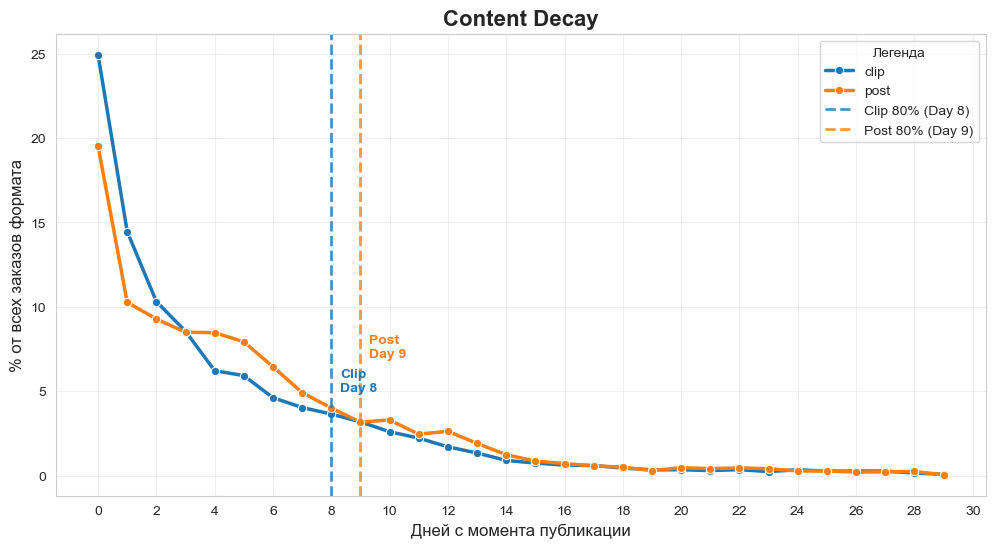

In [51]:
df_full['order_created_at'] = pd.to_datetime(df_full['order_created_at'], errors='coerce')
df_full['published_at'] = pd.to_datetime(df_full['published_at'], errors='coerce')

sns.set_style("whitegrid")



df_decay = df_full.dropna(subset=['order_created_at', 'published_at', 'placement_format']).copy()

# Считаем дельту в днях
df_decay['days_since_publish'] = (df_decay['order_created_at'] - df_decay['published_at']).dt.days

df_decay = df_decay[(df_decay['days_since_publish'] >= 0) & (df_decay['days_since_publish'] <= 30)]


decay_counts = df_decay.groupby(['placement_format', 'days_since_publish']).size().reset_index(name='orders_count')


decay_counts = decay_counts.sort_values(['placement_format', 'days_since_publish'])
total_orders_by_format = decay_counts.groupby('placement_format')['orders_count'].transform('sum')


decay_counts['percent_of_total'] = (decay_counts['orders_count'] / total_orders_by_format) * 100


decay_counts['cumulative_percent'] = decay_counts.groupby('placement_format')['percent_of_total'].cumsum()


plt.figure(figsize=(12, 6))

sns.lineplot(
    data=decay_counts,
    x='days_since_publish',
    y='percent_of_total',
    hue='placement_format',
    marker='o',
    linewidth=2.5,
    palette={'clip': '#1f77b4', 'post': '#ff7f0e'}
)


colors = {'clip': '#1f77b4', 'post': '#ff7f0e'}

for fmt in ['clip', 'post']:
    
    subset = decay_counts[decay_counts['placement_format'] == fmt]
    
    day_80 = subset[subset['cumulative_percent'] >= 80]['days_since_publish'].min()
    
    if pd.notna(day_80):
        color = colors.get(fmt, 'black')
        plt.axvline(x=day_80, color=color, linestyle='--', linewidth=2, alpha=0.8, 
                    label=f'{fmt.capitalize()} 80% (Day {day_80:.0f})')
        
        if fmt=='clip':
            pos=5
        else:
            pos = 7
        plt.text(day_80 + 0.3, pos, f"{fmt.capitalize()}\nDay {day_80:.0f}", 
                 color=color, fontweight='bold', ha='left')
plt.title('Content Decay', fontsize=16, fontweight='bold')
plt.xlabel('Дней с момента публикации', fontsize=12)
plt.ylabel('% от всех заказов формата', fontsize=12)
plt.xticks(np.arange(0, 31, 2))
plt.grid(True, alpha=0.3)
plt.legend(title='Легенда')

plt.show()


Линиями отмечены дни, в течении которых совершается 80 процентов заказов от размещения. Большинство заказов соверщаются в первые 8-9 дней размещения.

Теперь посмотрим на retention авторов

NameError: name 'ticker' is not defined

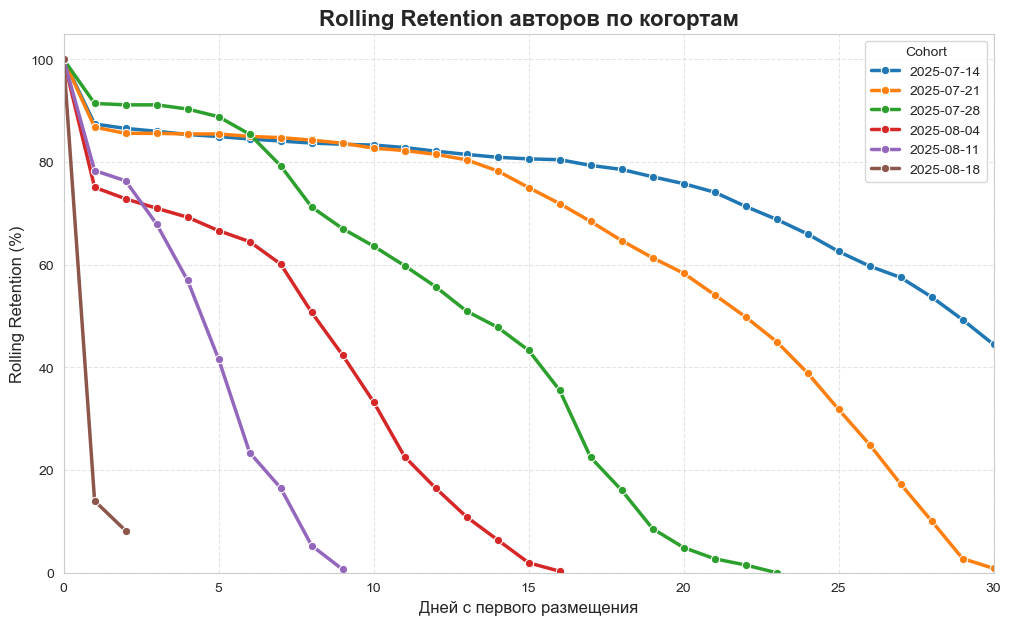

In [52]:

df = df_full[['hash_author_id', 'placement_created_at']].dropna().copy()


# Группируем по авторам
author_stats = df.groupby('hash_author_id')['placement_created_at'].agg(['min', 'max']).reset_index()
author_stats.columns = ['author_id', 'first_date', 'last_date']


df['placement_created_at'] = df['placement_created_at'].dt.tz_localize(None)
author_stats['first_date'] = author_stats['first_date'].dt.tz_localize(None)
author_stats['last_date'] = author_stats['last_date'].dt.tz_localize(None)


author_stats['cohort_week'] = author_stats['first_date'].dt.to_period('W').dt.start_time


author_stats['lifetime_days'] = (author_stats['last_date'] - author_stats['first_date']).dt.days


days_range = range(0, 31) 
cohorts = sorted(author_stats['cohort_week'].unique())

global_max_date = df['placement_created_at'].max() 

rolling_data = []

for cohort in cohorts:
    cohort_users = author_stats[author_stats['cohort_week'] == cohort]
    cohort_size = len(cohort_users)
    
    if cohort_size < 10: 
        continue
        
    
    max_cohort_age = (global_max_date - cohort).days
    
    for day in days_range:
        if day > max_cohort_age:
            continue
            
        retained_count = (cohort_users['lifetime_days'] >= day).sum()
        
        rolling_data.append({
            'Cohort': cohort.strftime('%Y-%m-%d'),
            'Day': day,
            'Rolling Retention': (retained_count / cohort_size) * 100
        })




df_rolling = pd.DataFrame(rolling_data)

plt.figure(figsize=(12, 7))

sns.lineplot(
    data=df_rolling,
    x='Day',
    y='Rolling Retention',
    hue='Cohort',
    palette="tab10", 
    linewidth=2.5,
    marker='o'
)


plt.title('Rolling Retention авторов по когортам', fontsize=16, fontweight='bold')
plt.ylabel('Rolling Retention (%)', fontsize=12)
plt.xlabel('Дней с первого размещения', fontsize=12)

plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.ylim(0, 105) 
plt.xlim(0, 30)  

plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter())


plt.legend(title='Неделя прихода', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


Старые когорты (июль) показывают отличный retention. Линии идут высоко и полого. Например, когорта от 2025-07-14 даже на 30-й день имеет retention выше 40%. Это крутой результат, означающий, что почти половина авторов остается активной спустя месяц.

Новые когорты (август) показывают резкое ухудшение.
Когорта 2025-08-04 падает в ноль к 15-му дню.

Резкое падение остальных когорт может быть связано с прекращением эксперимента во второй половине августа. Как мы видели ранее, поток офферов рекламы и размещений резко падает, что может говорить о сворачиваии программы.